**Part 1: Read and Process Data**

In [9]:
from glob import glob
from pathlib import Path
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
#to access the files
all_file_path = glob('/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/*.edf')
print(len(all_file_path))

28


In [6]:
all_file_path[0]

'/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/s01.edf'

In [11]:
print(all_file_path)


['/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/s01.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/h01.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/h14.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/s14.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/s02.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/h02.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/h03.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/s03.edf', '/Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/s07.edf', '/Users/folasewaabdulsalam/Signal_Processing/

In [13]:


# Splitting the data file path into healthy and schizophrenia patients

healthy_file_path = [i for i in all_file_path if 'h' in i.split('/')[-1]]  # Extract filename using '/'
schizo_patient_file_path = [i for i in all_file_path if 's' in i.split('/')[-1]]  # Extract filename using '/'

print(len(healthy_file_path), len(schizo_patient_file_path))


14 14


In [14]:
#a function to read the path and get the data from it
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path, preload=True)
    data.set_eeg_reference() #set the channel references, this line of code will get set the reference as an average of the channels
    data.filter(l_freq = 0.5, h_freq = 45) #setting low frequency as 0.5 and high frequency as 45
    epochs = mne.make_fixed_length_epochs(data, duration=5, overlap = 1) #split the data into segments
    array = epochs.get_data() #this will convert the data to a numpy array
    return array



In [15]:
#let us read a data
sample_data = read_data(healthy_file_path[0])

Extracting EDF parameters from /Users/folasewaabdulsalam/Signal_Processing/Schizophrenia_Classification/schizophrenia_dataset/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1651 samples (6.604 s)

Not setting metadata
231 matching events found
N

In [16]:
sample_data.shape #231 - no of epochs, 19 - no of channels, 1250, length of signal

(231, 19, 1250)

In [18]:
import sys
import os

# Suppress output
class SuppressOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    
    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout
# Wrap in SuppressOutput context manager
with SuppressOutput(): #mainly using %%capture could have worked if I were using a jupyter kernel, but since it is on vscode, I had to create a function called suppress outout and wrap my lines of code
    #let's read all the files, the use of capture is to not allow those information above to print for all the data
    healthy_epochs_array = [read_data(i) for i in healthy_file_path]
    schizo_epochs_array = [read_data(i) for i in schizo_patient_file_path]

In [19]:
healthy_epochs_array[0].shape

(231, 19, 1250)

In [20]:
#creating a label 0 for healthy, 1 for schizo
healthy_epochs_labels = [len(i)*[0] for i in healthy_epochs_array]
schizo_epochs_labels = [len(i)*[1] for i in schizo_epochs_array]
len(healthy_epochs_labels), len(schizo_epochs_labels)

(14, 14)

In [21]:
#combining both of the files - the data array and the label
data_list = healthy_epochs_array + schizo_epochs_array
label_list = healthy_epochs_labels + schizo_epochs_labels


In [22]:
#splitting the data based on subject and not on epochs or channels, therefore we assign a group to each subject making 28 groups
group_list =[[i]*len(j) for i, j in enumerate(data_list)]
len(group_list)

28

In [23]:
data_array = np.vstack(data_list) #combines array vertically
label_array = np.hstack(label_list) #combines array horizontally
group_array = np.hstack(group_list)

print(data_array.shape, label_array.shape, group_array.shape)

(7201, 19, 1250) (7201,) (7201,)


In [25]:
#we want to get different features from this data
from scipy import stats

def mean(x):
    return np.mean(x, axis = -1)

def std(x):
    return np.std(x, axis = -1)

def ptp(x):
    return np.ptp(x, axis = -1)

def var(x):
    return np.var(x, axis = -1)

def minim(x):
    return np.min(x, axis = -1)

def maxim(x):
    return np.max(x, axis = -1)

def argminim(x):
    return np.argmin(x, axis = -1)

def argmaxim(x):
    return np.argmax(x, axis = -1)

def rms(x):
    return np.sqrt(np.mean(x**2, axis = -1))

def abs_diff_signal(x):
    return np.sum(np.abs(np.diff(x, axis = -1)), axis = -1)

def skewness(x):
    return stats.skew(x, axis = -1)

def kurtosis(x):
    return stats.kurtosis(x, axis = -1)

def concatenate_features(x):
    return np.concatenate((mean(x), std(x), ptp(x), var(x), minim(x), maxim(x), 
                          argmaxim(x), argminim(x), rms(x), abs_diff_signal(x), skewness(x), kurtosis(x)), axis = -1)



In [26]:
#let us run a loop to extract these features

extracted_features = []

for data in data_array:
    extracted_features.append(concatenate_features(data))

In [27]:
extracted_features_array = np.array(extracted_features)
extracted_features_array.shape


(7201, 228)

**Part 2: Machine Learning Classification**

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GridSearchCV




In [35]:
logReg = LogisticRegression()
grpKfold = GroupKFold(5)
pipe_line = Pipeline([('scaler', StandardScaler()), ('logReg', logReg)])
param_grid = {'logReg__C': [0.1, 0.5, 0.7, 1, 3, 5, 7]}
grid_search = GridSearchCV(pipe_line, param_grid, cv = grpKfold, n_jobs=12)
grid_search.fit(extracted_features_array, label_array, groups = group_array)


/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

GridSearchCV(cv=GroupKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logReg', LogisticRegression())]),
             n_jobs=12, param_grid={'logReg__C': [0.1, 0.5, 0.7, 1, 3, 5, 7]})

In [36]:
grid_search.best_score_

np.float64(0.6564742404858336)

Part 3: Deep Learning with CNN

In [37]:
#checking the shape of each array
data_array.shape, label_array.shape, group_array.shape #1250 is the length, 19 is the no of channels, 7201 is the no of segment

((7201, 19, 1250), (7201,), (7201,))

In [40]:
#cnn requires the channel to be at the end, so we move the channel to the end

data_array = np.moveaxis(data_array, 1, 2)
data_array.shape

(7201, 1250, 19)

In [45]:
from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session

def cnnmodel():
    clear_session()
    model = Sequential()
    model.add(Conv1D(filters = 5, kernel_size = 3, strides = 1, input_shape = (1250, 19))) #input layer
    model.add(BatchNormalization())
    model.add(LeakyReLU()) #activation function
    model.add(MaxPool1D(pool_size = 2, strides = 2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters = 5, kernel_size = 3, strides = 1)) #2nd layer
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size = 2, strides = 2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters = 5, kernel_size = 3, strides = 1)) #3rd layer
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size = 2, strides = 2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters = 5, kernel_size = 3, strides = 1)) #4th layer
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size = 2, strides = 2))
    model.add(Dropout(0.5))

    model.add(Conv1D(filters = 5, kernel_size = 3, strides = 1)) #output layer
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(1, activation = 'sigmoid')) #dense is 1 because we are classifying whether the person has schizo or not, label 0 or 1

    model.compile('adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

model = cnnmodel()
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1248, 5)        │           290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1248, 5)        │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 1248, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 624, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 624, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 622, 5)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 622, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 311, 5)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 311, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 309, 5)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 309, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 154, 5)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 154, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 152, 5)         │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 152, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 76, 5)          │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 76, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 74, 5)          │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 74, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 5)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 636 (2.48 KB)

 Trainable params: 626 (2.45 KB)

 Non-trainable params: 10 (40.00 B)

In [64]:
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut #for cross validation
from sklearn.preprocessing import StandardScaler #to scale the dataset



In [83]:
#manually reserve a test group from the validation group

unique_groups = np.unique(group_array)

# Select one group from each class
test_groups_class_0 = [0]  # Choose a group containing class 0
test_groups_class_1 = [14]  # Choose a group containing class 1

# Combine selected groups for the test set
test_groups = test_groups_class_0 + test_groups_class_1
test_indices = np.where(np.isin(group_array, test_groups))[0]

# Create the test set
test_features, test_labels = data_array[test_indices], label_array[test_indices]

# Remove test set from train_val data
train_val_indices = np.where(~np.isin(group_array, test_groups))[0]
train_val_features, train_val_labels = data_array[train_val_indices], label_array[train_val_indices]
train_val_groups = group_array[train_val_indices]

# Verify test set distributions
print("Test Labels Distribution:", np.unique(test_labels, return_counts=True))
print("Test Groups Distribution:", np.unique(group_array[test_indices], return_counts=True))




Test Labels Distribution: (array([0, 1]), array([231, 211]))
Test Groups Distribution: (array([ 0, 14]), array([231, 211]))


In [84]:
from sklearn.model_selection import StratifiedGroupKFold
import numpy as np

# Initialize StratifiedGroupKFold
strat_grp_kfold = StratifiedGroupKFold(n_splits=5)

accuracy = []

# Perform stratified splits with group constraints
for train_index, val_index in strat_grp_kfold.split(train_val_features, train_val_labels, groups=train_val_groups):
    train_features, train_labels = train_val_features[train_index], train_val_labels[train_index]
    val_features, val_labels = train_val_features[val_index], train_val_labels[val_index]

    # Check label distributions for balance
    print("Train Labels Distribution:", np.unique(train_labels, return_counts=True))
    print("Validation Labels Distribution:", np.unique(val_labels, return_counts=True))

    # Standardize features
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)

    # Train model
    model = cnnmodel()
    model.fit(train_features, train_labels, epochs=10, batch_size=100, validation_data=(val_features, val_labels))

    # Append validation accuracy
    accuracy.append(model.evaluate(val_features, val_labels)[1])  # accuracy is at index 1

# Print cross-validation results
print(f"Cross-Validation Average Accuracy: {np.mean(accuracy) * 100:.2f}%")


Train Labels Distribution: (array([0, 1]), array([2341, 2970]))
Validation Labels Distribution: (array([0, 1]), array([679, 769]))


/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5530 - loss: 0.6837 - val_accuracy: 0.5311 - val_loss: 0.6722
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5588 - loss: 0.6750 - val_accuracy: 0.5318 - val_loss: 0.6705
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5646 - loss: 0.6662 - val_accuracy: 0.5532 - val_loss: 0.6594
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6082 - loss: 0.6519 - val_accuracy: 0.6837 - val_loss: 0.6322
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7055 - loss: 0.6196 - val_accuracy: 0.6678 - val_loss: 0.5945
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7071 - loss: 0.5880 - val_accuracy: 0.6796 - val_loss: 0.5620
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7484 - loss: 0.5378 - val_accuracy: 0.7113 - val_loss: 0.5304
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7537 - loss: 0.5192 - val_accuracy: 0.8080 - v

/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4970 - loss: 0.6938 - val_accuracy: 0.6312 - val_loss: 0.6683
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5547 - loss: 0.6789 - val_accuracy: 0.6312 - val_loss: 0.6658
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5751 - loss: 0.6542 - val_accuracy: 0.5532 - val_loss: 0.6729
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7387 - loss: 0.5596 - val_accuracy: 0.6950 - val_loss: 0.6126
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7764 - loss: 0.4984 - val_accuracy: 0.7305 - val_loss: 0.5882
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8244 - loss: 0.4412 - val_accuracy: 0.5437 - val_loss: 0.6994
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8351 - loss: 0.4120 - val_accuracy: 0.5737 - val_loss: 0.7096
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8483 - loss: 0.3851 - val_accuracy: 0.6485 - v

/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4467 - loss: 0.7537 - val_accuracy: 0.4676 - val_loss: 0.7022
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5188 - loss: 0.6919 - val_accuracy: 0.5423 - val_loss: 0.6896
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5627 - loss: 0.6875 - val_accuracy: 0.5450 - val_loss: 0.6857
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5612 - loss: 0.6859 - val_accuracy: 0.5414 - val_loss: 0.6888
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5892 - loss: 0.6791 - val_accuracy: 0.5297 - val_loss: 0.6942
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6006 - loss: 0.6673 - val_accuracy: 0.5612 - val_loss: 0.6695
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6871 - loss: 0.6060 - val_accuracy: 0.6556 - val_loss: 0.6391
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7410 - loss: 0.5468 - val_accuracy: 0.6871 - v

/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5574 - loss: 0.6787 - val_accuracy: 0.5286 - val_loss: 0.6914
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5707 - loss: 0.6562 - val_accuracy: 0.4983 - val_loss: 0.6947
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5849 - loss: 0.6385 - val_accuracy: 0.4762 - val_loss: 0.7058
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6374 - loss: 0.6240 - val_accuracy: 0.4838 - val_loss: 0.7197
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6964 - loss: 0.5764 - val_accuracy: 0.4700 - val_loss: 0.7788
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7069 - loss: 0.5697 - val_accuracy: 0.4686 - val_loss: 0.7921
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7298 - loss: 0.5551 - val_accuracy: 0.4700 - val_loss: 0.8161
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7284 - loss: 0.5462 - val_accuracy: 0.4707 - v

/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5605 - loss: 0.6679 - val_accuracy: 0.5321 - val_loss: 0.6948
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5654 - loss: 0.6432 - val_accuracy: 0.4402 - val_loss: 0.7028
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6377 - loss: 0.6190 - val_accuracy: 0.4611 - val_loss: 0.7112
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7022 - loss: 0.5862 - val_accuracy: 0.4632 - val_loss: 0.7254
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7689 - loss: 0.5351 - val_accuracy: 0.4733 - val_loss: 0.7653
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7533 - loss: 0.5300 - val_accuracy: 0.4713 - val_loss: 0.7743
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7549 - loss: 0.5239 - val_accuracy: 0.4713 - val_loss: 0.7966
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7568 - loss: 0.5363 - val_accuracy: 0.4706 - v

Evaluate the model on the reserved test set

In [85]:
# Evaluate on test set

# Standardize test set
test_features = scaler.transform(test_features.reshape(-1, test_features.shape[-1])).reshape(test_features.shape)

# Evaluate on test set
test_accuracy = model.evaluate(test_features, test_labels, verbose=0)
print(f"Test Accuracy: {test_accuracy[1] * 100:.2f}%")




Test Accuracy: 52.71%


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


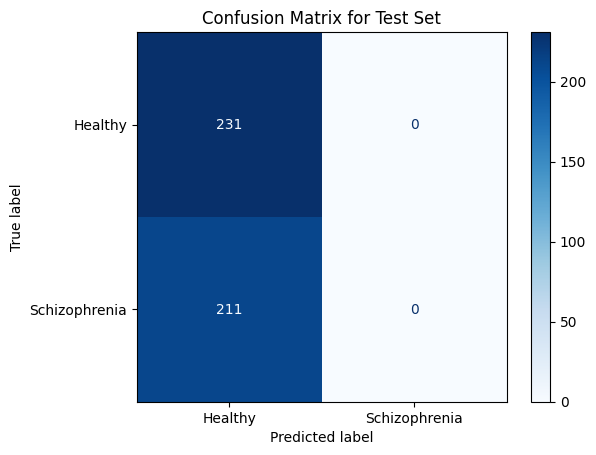

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
y_pred = np.argmax(model.predict(test_features), axis=1)  # Get predicted classes
y_true = test_labels  # True labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Schizophrenia'])
disp.plot(cmap='Blues', values_format='d')  # Use 'Blues' for a clearer color scale
plt.title("Confusion Matrix for Test Set")
plt.show()



In [89]:
y_pred = np.argmax(model.predict(test_features), axis=1)
print("Predicted Labels Distribution:", np.unique(y_pred, return_counts=True))



14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicted Labels Distribution: (array([0]), array([442]))


In [70]:
for i in range(5):  # Change range to check more examples
    prediction = model.predict(test_features[i:i+1])[0][0]  # Probability for binary classification
    actual = test_labels[i]
    print(f"Sample {i+1}: Predicted = {prediction:.2f}, Actual = {actual}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sample 1: Predicted = 0.85, Actual = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample 2: Predicted = 0.41, Actual = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 3: Predicted = 0.73, Actual = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sample 4: Predicted = 0.49, Actual = 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Sample 5: Predicted = 0.26, Actual = 1


In [72]:
print("Updated test Labels Distribution:", np.bincount(test_labels))


Updated test Labels Distribution: [  0 296]


In [63]:
accuracy = []
for train_index, val_index in grpKfold.split(data_array, label_array, groups = group_array):
    
    train_features, train_labels = data_array[train_index], label_array[train_index]
    val_features, val_labels = data_array[val_index], label_array[val_index]

    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features.reshape(-1, \
                                                                 train_features.shape[-1])).reshape(train_features.shape)
     #basically, that reshape will make the array have a column 19, and row which is the product of the first two elements, thereby making it a 2D data
    val_features = scaler.transform(val_features.reshape(-1,\
                                                               val_features.shape[-1])).reshape(val_features.shape)
    model = cnnmodel()
    model.fit(train_features, train_labels, epochs = 10, batch_size = 100, validation_data = (val_features, val_labels))

    accuracy.append(model.evaluate(val_features, val_labels)[1]) #accuracy is at index 1, loss is at index 0

    break


/Users/folasewaabdulsalam/Signal_Processing/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.5897 - loss: 0.6742 - val_accuracy: 0.3699 - val_loss: 0.7276
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5941 - loss: 0.6513 - val_accuracy: 0.3953 - val_loss: 0.7233
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6600 - loss: 0.6174 - val_accuracy: 0.5745 - val_loss: 0.7740
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7376 - loss: 0.5497 - val_accuracy: 0.6362 - val_loss: 0.7797
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7830 - loss: 0.4960 - val_accuracy: 0.6651 - val_loss: 0.8165
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7899 - loss: 0.4791 - val_accuracy: 0.6788 - val_loss: 0.8331
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8055 - loss: 0.4509 - val_accuracy: 0.7117 - val_loss: 0.8491
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8238 - loss: 0.4361 - val_accuracy: 0.7275 - v

(6970, 1250, 19)